In [12]:
import os
import sys
sys.path.append(os.path.abspath('..'))

In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

In [26]:
training_reports_dir = "/Users/masterbee/Desktop/AIMS-PROJECT/models/reports/training/"
finetuning_reports_dir = "/Users/masterbee/Desktop/AIMS-PROJECT/models/reports/classification/"
plots_dir = "/Users/masterbee/Desktop/AIMS-PROJECT/models/plots/"

In [15]:
rename_features = {
    'fcgr_64': 'FCGR-64',
    'fcgr_128': 'FCGR-128',
    'kmer_5': '5-mers',
    'kmer_6': '6-mers',
    'kmer_7': '7-mers',
    'kmer_8': '8-mers',
    'murugaiah': 'Murugaiah'
}

In [16]:
def read_data_from_flat_report(report_path:str):
    with open(report_path, 'r') as f:
        for line in f.readlines():
            if "accuracy" in line:
                accuracy = float(line.split()[1])
            if "weighted avg" in line:
                precision = float(line.split()[2])
                recall = float(line.split()[3])
                f1 = float(line.split()[4])
            if "MCC" in line:
                mcc = round(float(line.split()[1]), 2)

    return accuracy, precision, recall, f1, mcc

def read_data_from_h_report(report_path:str):
    with open(report_path, 'r') as f:
        for line in f.readlines():
            if "Precision" in line:
                precision = round(float(line.split()[1]), 2)
            if "Recall" in line:
                recall = round(float(line.split()[1]), 2)
            if "F1-score" in line:
                f1 = round(float(line.split()[1]), 2)

    return precision, recall, f1

def get_features(report_path:str):
    return report_path.split('_tts_')[-1].split('.')[0]

In [17]:
def get_flat_model_summary(model:str):
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}
    mcc_dict = {}

    training_reports = [os.path.join(training_reports_dir, path) for path in os.listdir(training_reports_dir)]

    for report in training_reports:
        if "flat" in report and model in report:
            accuracy, precision, recall, f1, mcc = read_data_from_flat_report(report)
            features = get_features(report)
            accuracy_dict[features] = accuracy
            precision_dict[features] = precision
            recall_dict[features] = recall
            f1_dict[features] = f1
            mcc_dict[features] = mcc
    
    return accuracy_dict, precision_dict, recall_dict, f1_dict, mcc_dict

def get_hierarchical_model_summary(htype:str, model:str):
    precision_dict = {}
    recall_dict = {}
    f1_dict = {}

    training_reports = [os.path.join(training_reports_dir, path) for path in os.listdir(training_reports_dir)]
    
    for report in training_reports:
        if htype in report and model in report:
            precision, recall, f1 = read_data_from_h_report(report)
            features = get_features(report)
            precision_dict[features] = precision
            recall_dict[features] = recall
            f1_dict[features] = f1
    
    return precision_dict, recall_dict, f1_dict
    
def get_model_summary(htype:str, model:str):
    if htype == "flat":
        return get_flat_model_summary(model)
    else:
        return get_hierarchical_model_summary(htype, model)


In [87]:
def plot_grouped_histogram(htype:str, model:str, save:bool=True, ylim:float=1.05):
    if htype == "flat":
        accuracy, precision, recall, f1, mcc = get_model_summary(htype, model)
        data = {
            'Accuracy': accuracy,
            'F1 Score': f1,
            'MCC': mcc,
            'Precision': precision,
            'Recall': recall,
            
        }
    else:
        precision, recall, f1 = get_model_summary(htype, model)
        data = {
            'Precision': precision,
            'F1 Score': f1,
            'Recall': recall,
        }

    df = pd.DataFrame(data)
    df = df.T
    df = df.reindex(sorted(df.columns), axis=1)
    df.columns = [rename_features[col] for col in df.columns]
    
    if df.empty:
        print(f"No data found for {htype} {model}")
        return
    
    ax = df.plot(kind='bar', figsize=(12, 7))
    ax.set_xticklabels(df.index, rotation=45, ha='right')

    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.2f}', 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='bottom', rotation=90, xytext=(0, 5), textcoords='offset points'
        )

    plt.xlabel('Metrics')
    plt.ylabel('Scores')
    plt.ylim(0, ylim)
    # plt.title('Performance Metrics by Feature')
    plt.legend(title='Features', bbox_to_anchor=(1.05, 0.66), loc='upper left')
    plt.tight_layout()

    if save:
        path = os.path.join(plots_dir, f'grouped_histogram_{htype}_{model}.png')
        plt.savefig(path, dpi=600, bbox_inches='tight')

    plt.show()

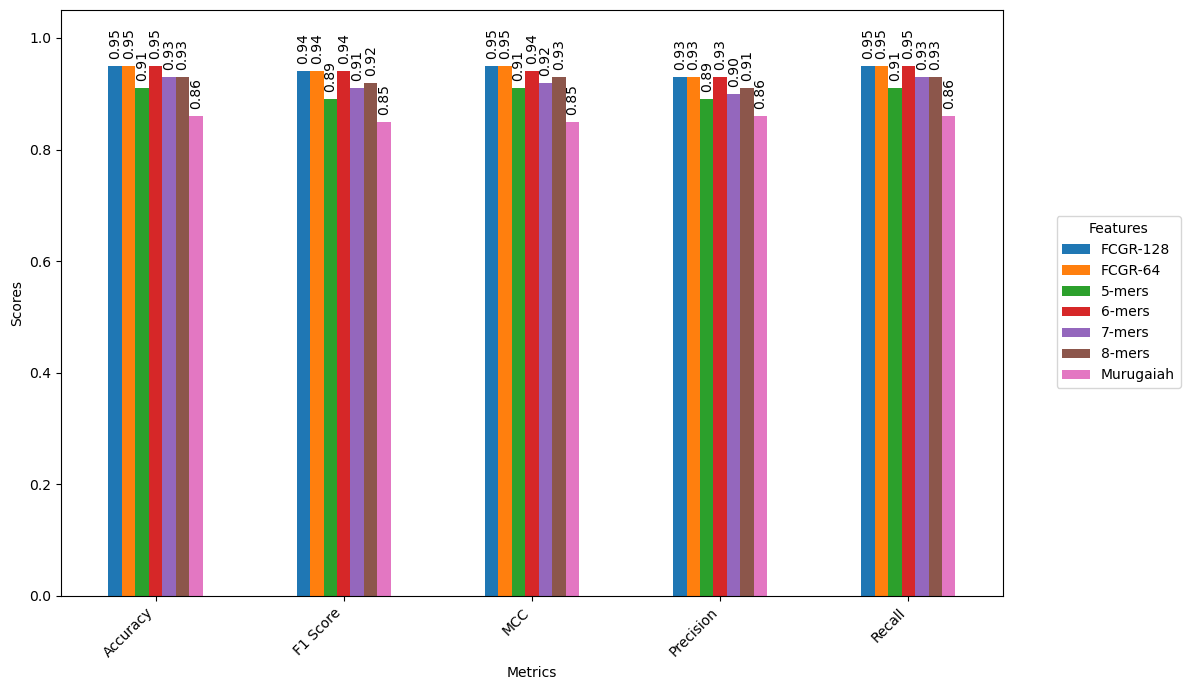

In [88]:
plot_grouped_histogram(htype='flat', model='rf', save=True)

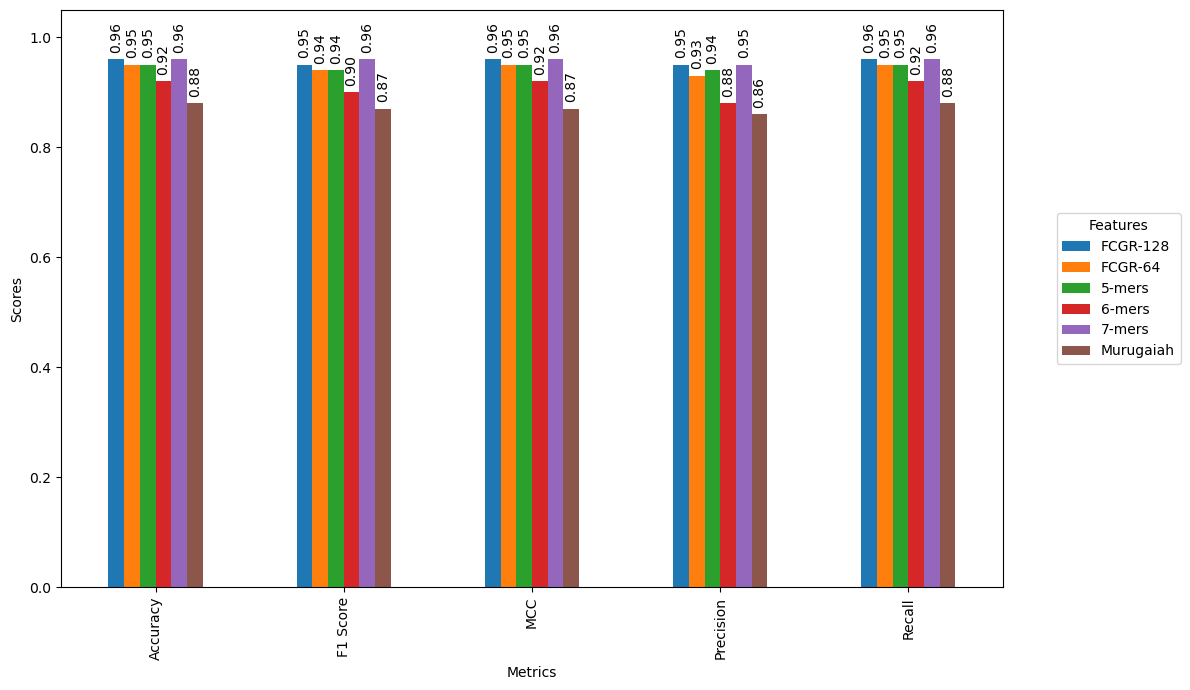

In [71]:
plot_grouped_histogram(htype='flat', model='xgb', save=True)

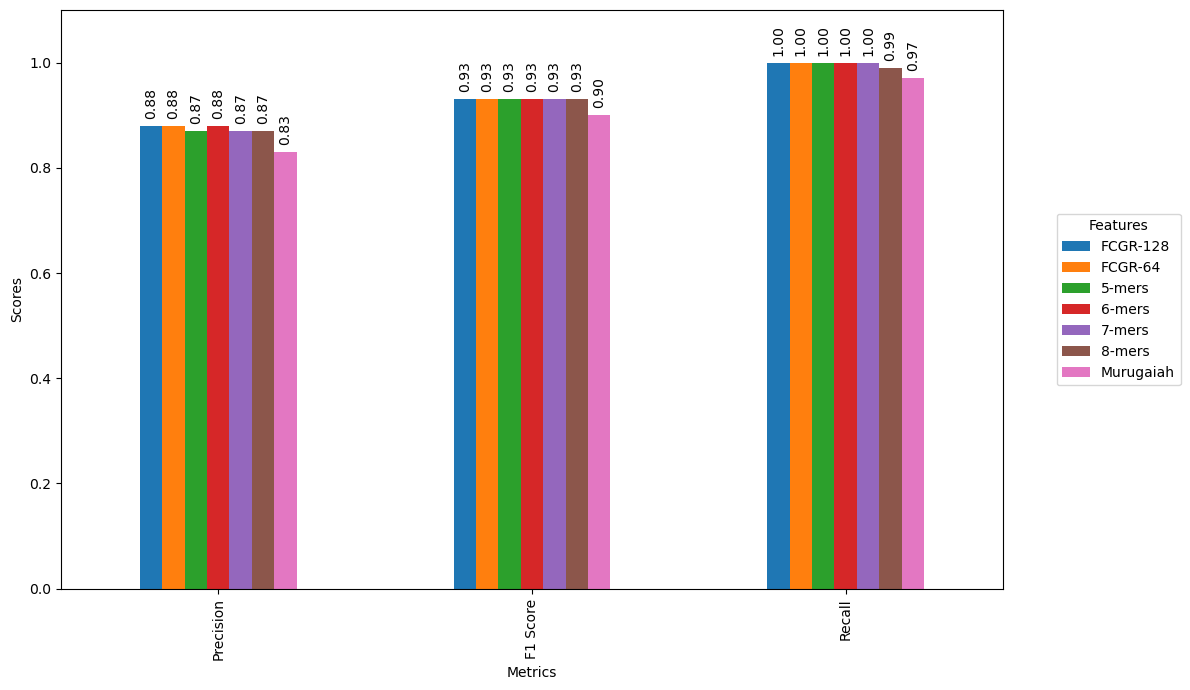

In [72]:
plot_grouped_histogram(htype='lcpl', model='rf', ylim=1.1, save=True)

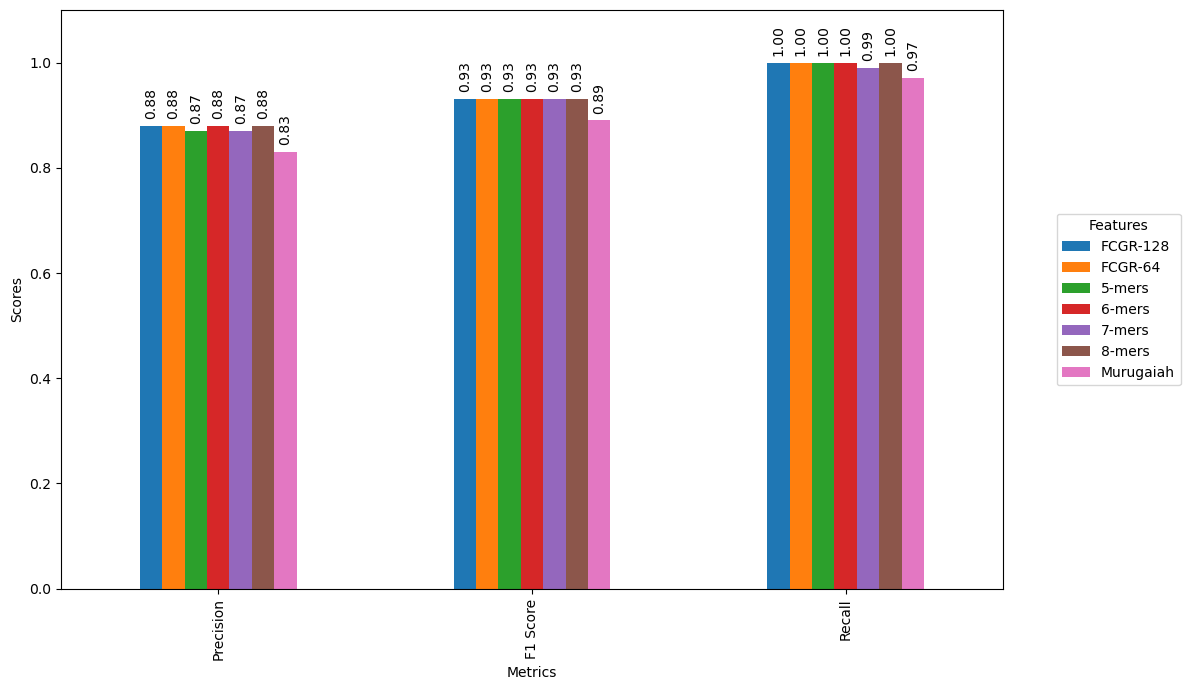

In [73]:
plot_grouped_histogram(htype='lcppn', model='rf', ylim=1.1, save=True)

In [23]:
plot_grouped_histogram(htype='lcpn', model='rf', ylim=1.1, save=True)

No data found for lcpn rf


### TASKS

1. Sort features on grouped hist plots

# Plots for hyper params

In [32]:
def read_hyperparams_from_report(report_path:str):
    with open(report_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("Best hyperparameters:"):
                hyperparams_str = line.split("Best hyperparameters: ")[1].strip()
                hyperparams_dict = ast.literal_eval(hyperparams_str)
                return hyperparams_dict
        raise ValueError(f"Best hyperparameters not found in {report_path}")


def get_model_hyperparams_summary(htype:str, model:str):
    optimal_hyperparameters = {}
    reports = [os.path.join(finetuning_reports_dir, path) for path in os.listdir(finetuning_reports_dir)]

    for report in reports:
        if htype in report and model in report and 'cv' not in report:
            params = read_hyperparams_from_report(report)
            feature = get_features(report)
            optimal_hyperparameters[feature] = params

    return optimal_hyperparameters

In [37]:
dict_key_to_readable = {
    "fcgr_64": "FCGR-64",
    "fcgr_128": "FCGR-128",
    "kmer_5": "5-mers",
    "kmer_6": "6-mers",
    "kmer_7": "7-mers",
    "kmer_8": "8-mers",
    "murugaiah": "Murugaiah"
}

In [130]:
def plot_hyperparameters_subplot(htype: str, model: str, round:bool=True, save: bool=True):
    optimal_hyperparameters = get_model_hyperparams_summary(htype=htype, model=model)
    optimal_hyperparameters = {k: v for k, v in sorted(optimal_hyperparameters.items(), key=lambda item: item[0])}
    hyperparams = list(optimal_hyperparameters[list(optimal_hyperparameters.keys())[0]].keys())

    fig, axes = plt.subplots(2, 3, figsize=(11, 6))
    axes = axes.flatten()

    for i, hyperparam in enumerate(hyperparams):
        values = [optimal_hyperparameters[feature][hyperparam] for feature in optimal_hyperparameters]
        
        features = [dict_key_to_readable[feature] for feature in optimal_hyperparameters]
        
        axes[i].bar(features, values, color='skyblue', edgecolor='black', linewidth=1.2)

        # Find the highest patch height
        max_height = max([p.get_height() for p in axes[i].patches])
        
        for p in axes[i].patches:
            val = int(p.get_height()) if round else round(p.get_height(), 2)
            axes[i].annotate(
                f'{val}',
                (p.get_x() + p.get_width() / 2., max_height * 0.4),#p.get_height()*0.35),
                fontsize=10,
                ha='center', va='bottom', rotation=0, xytext=(0, 5), textcoords='offset points'
            )
        
        axes[i].set_title(f'{hyperparam}', fontname='Courier New', fontsize=12)
        axes[i].xaxis.set_ticks(features)
        axes[i].set_xticklabels(features, rotation=45, ha='right', fontsize=10)
        axes[i].tick_params(axis='y', labelsize=10)

    # Hide empty subplot
    if len(hyperparams) < len(axes):
        for i in range(len(hyperparams), len(axes)):
            fig.delaxes(axes[i])

    plt.tight_layout()

    if save:
        path = os.path.join(plots_dir, f'hyperparameters_{htype}_{model}.pdf')
        plt.savefig(path, dpi=600, bbox_inches='tight', format='pdf')


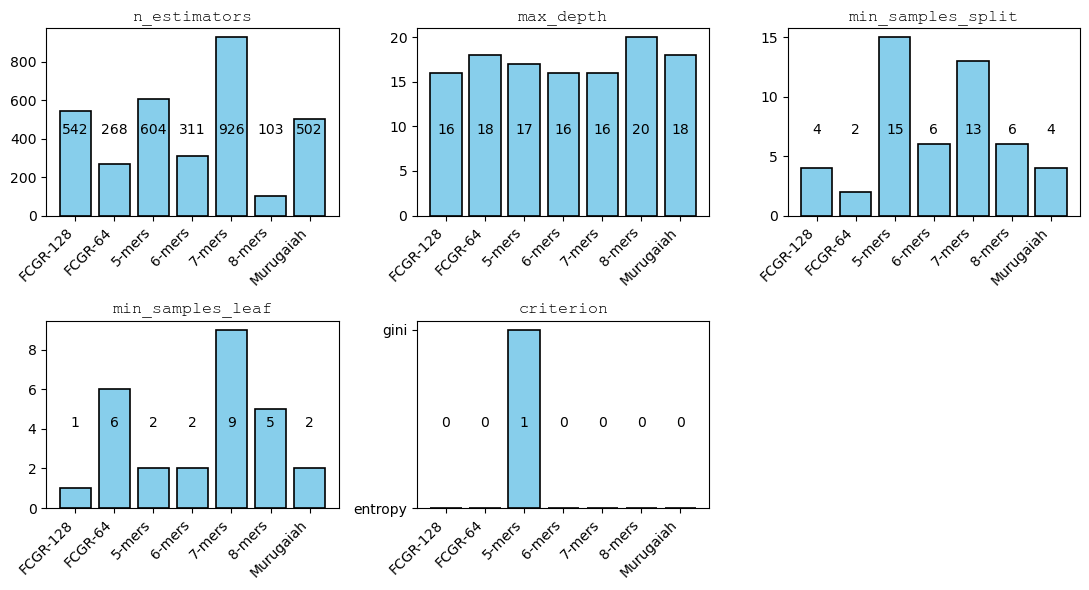

In [131]:
plot_hyperparameters_subplot(htype='flat', model='rf')

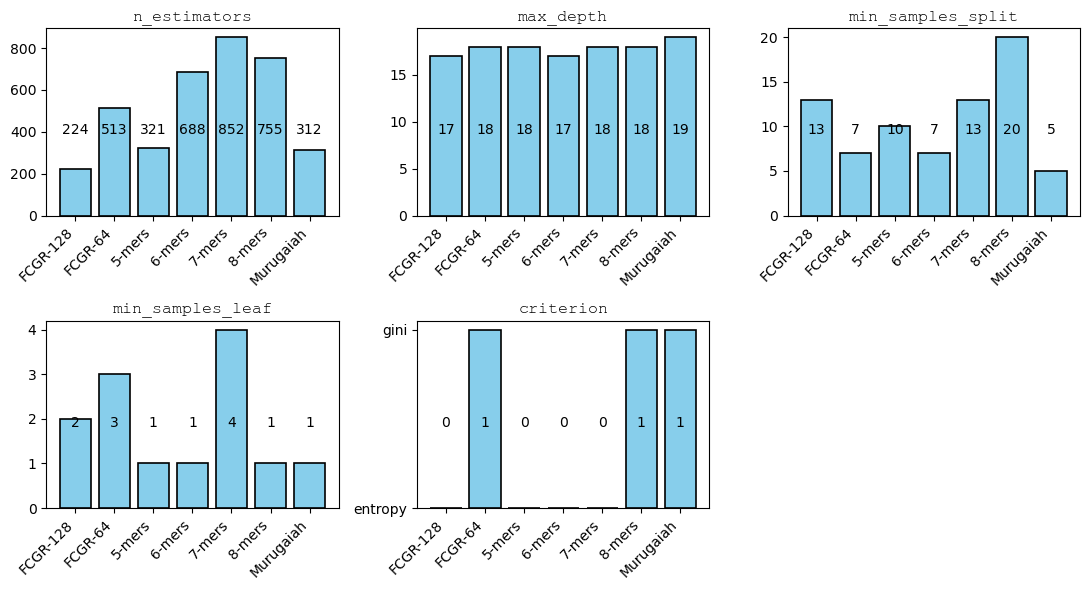

In [132]:
plot_hyperparameters_subplot(htype='lcpl', model='rf')

In [147]:
accuracy, precision, recall, f1, mcc = get_flat_model_summary('xgb')
mcc

{'kmer_5': 0.95,
 'kmer_7': 0.96,
 'kmer_6': 0.92,
 'murugaiah': 0.87,
 'fcgr_128': 0.96,
 'fcgr_64': 0.95}

In [155]:
precision, recall, f1 = get_hierarchical_model_summary('lcpn', 'rf')
f1

{}